# Black-Scholes with a k-neighbours regression and simple local weights
### Sam Porritt

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.neighbors import kneighbors_graph

In [2]:
# For ease of comparison, this function is essentially the same as in the notebook at:
# https://github.com/robbieculkin/black-scholes-NN

def CheckAccuracy(y,y_hat):
    
    stats = dict()
    stats['error'] = y - y_hat
    stats['mse'] = (stats['error']**2).mean()
    print ("Mean Squared Error:      ", stats['mse'])
    stats['rmse'] = np.sqrt(stats['mse'])
    print ("Root Mean Squared Error: ", stats['rmse'])
    stats['mae'] = (np.abs(stats['error'])).mean()
    print ("Mean Absolute Error:     ", stats['mae'])
    stats['mpe'] = np.sqrt(stats['mse'])/y.mean()
    print ("Mean Percent Error:      ", stats['mpe'])
    
    plt.figure(figsize=(10,7))
    plt.scatter(y, y_hat,color='black',linewidth=0.3,alpha=0.4, s=0.5)
    plt.xlabel('Actual Price',fontsize=20)
    plt.ylabel('Predicted Price',fontsize=20) 
    plt.show()
    
    plt.figure(figsize=(10,7))
    plt.hist(stats['error'], bins=150,edgecolor='black',color='blue')
    plt.xlabel('Error',fontsize=20)
    plt.ylabel('Density',fontsize=20)
    plt.show()
    
    return stats

In [3]:
class LocalLinear():
    
    def __init__(self, X, y, k):
        
        self.X_values = X
        self.y_values = y
        self.neighbours_graph = kneighbors_graph(X, k)

    def predict(self, x_index):
        
        x0 = self.X_values[x_index]
        x_neighbours_indices = self.neighbours_graph.getrow(x_index).nonzero()[1]
        x = np.array([self.X_values[i] for i in x_neighbours_indices])
        y = np.array([self.y_values[i] for i in x_neighbours_indices])
        kernel = 1 - np.array([sum((x0-xi)**2) for xi in x]) / max([sum((x0-xi)**2) for xi in x])
        
        return x0.dot(np.linalg.inv((kernel*(x.T)).dot(x)).dot((x.T).dot(kernel*y)))

In [4]:
df = pd.read_csv('training.csv').drop(columns=['Unnamed: 0'])
new_df = pd.DataFrame()
new_df['S'] = df['Stock Price'] / df['Strike Price']
new_df['C'] = df['Call Price'] / df['Strike Price']
new_df['rT'] = df['Maturity'] * df['Risk-free']
new_df['qT'] = df['Maturity'] * df['Dividends']
new_df['sigmaRootT'] = df['Volatility'] * np.sqrt(df['Maturity'])
# add all 1s feature so the linear regression formula applies
new_df['1'] = new_df['S']/new_df['S']
X, y = new_df.drop(columns=["C"]).values, new_df["C"].values

In [5]:
localLin = LocalLinear(X, y, k=30)

Mean Squared Error:       1.0438854518623162e-08
Root Mean Squared Error:  0.00010217071262657985
Mean Absolute Error:      6.582105431252619e-05
Mean Percent Error:       0.0003810734634643532


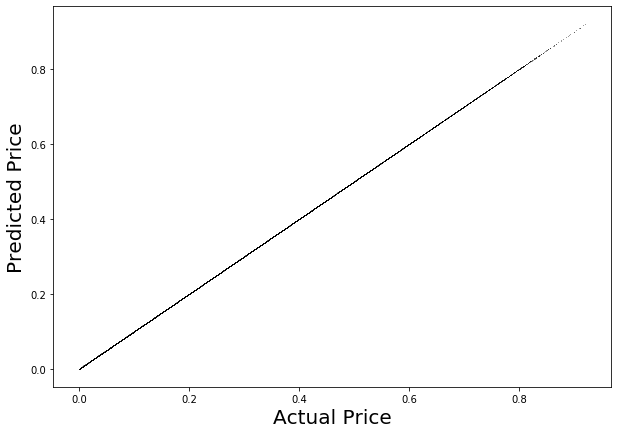

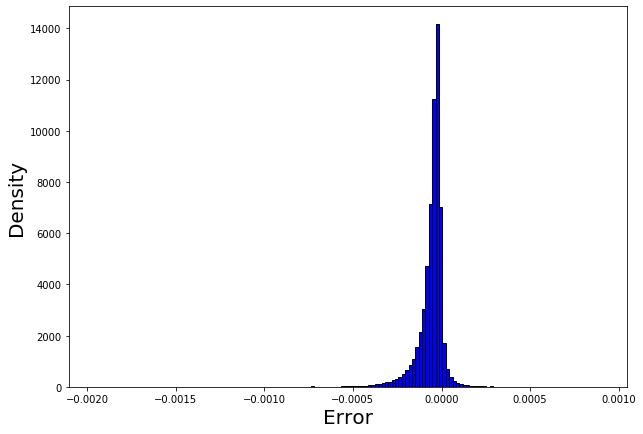

{'error': array([-1.42387467e-05, -3.68145443e-05, -4.13257144e-05, ...,
        -4.36323348e-04, -4.62733371e-05, -6.55401690e-05]),
 'mse': 1.0438854518623162e-08,
 'rmse': 0.00010217071262657985,
 'mae': 6.582105431252619e-05,
 'mpe': 0.0003810734634643532}

In [6]:
num_predictions = 60000
predictions = np.array([max(0, localLin.predict(i)) for i in range(num_predictions)])
CheckAccuracy(np.array(y[:num_predictions]), predictions)